In [1]:
#main file for our machine learning model - incoporates drill core from entire world

#reference information: 

#good help for setup of elephant SQL database!
#https://medium.com/@noogetz/how-to-setup-a-database-with-elephantsql-7d87ea9953d0

#good reference on XGboost parameters
#XGBoost inbalanced training set
#https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

#plots on map - reference for maps at the end of this notebook
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972

In [3]:
# Import dependencies
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import seaborn as sns
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt

#database
from sqlalchemy import create_engine
from sqlalchemy import join
from sqlalchemy.sql import select
import psycopg2
from urllib.parse import urlparse

#import machines learning modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from xgboost import plot_importance
import xgboost as xgboost

#mapping using geopandas, descartes & shapely
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

#file output
import json
from geojson import Feature, FeatureCollection, Point

In [ ]:
# Create an engine instance
#insert your own password in string below: 
conn_string= dbstringhere
alchemyEngine=create_engine(conn_string)

# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance
age = pd.read_sql("select * from \"Age\"", dbConnection);
computed = pd.read_sql("select * from \"Computed\"", dbConnection)
country = pd.read_sql("select * from \"Country\"", dbConnection)
isotope = pd.read_sql("select * from \"Isotope\"", dbConnection)
major = pd.read_sql("select * from \"Major\"", dbConnection)
rockgroup = pd.read_sql("select * from \"Rockgroup\"", dbConnection)
trace = pd.read_sql("select * from \"Trace\"", dbConnection)
sample = pd.read_sql("select * from \"Sample\"", dbConnection)

pd.set_option('display.expand_frame_repr', False);
dbConnection.close();

In [ ]:
#join the tables

a = sample.join(trace.set_index('trace_id'), on='trace_id', how = 'left')
b = a.join(major.set_index('major_id'), on='major_id', how = 'left')
c = b.join(isotope.set_index('iso_id'), on = 'iso_id', how = 'left')
d = c.join(age.set_index('age_id'), on = 'age_id', how = 'left')
e = d.join(computed.set_index('comp_id'), on = 'comp_id', how ='left')
f = e.join(country.set_index('country_id'), on = 'country_id', how ='left')
df = f.join(rockgroup.set_index('rgroup_id'), on = 'rgroup_id', how = 'left')

#df = fulldataframe - can continue on with this one! 


In [5]:
df.head()

,sample_id,sample_name,latitude,longitude,rock_name,quartz,feldspar,lithics,p_velocity,density_model,heat_production,heat_production_mass,trace_id,iso_id,comp_id,major_id,rgroup_id,age_id,country_id,f_ppm,cl_ppm,br__ppm,i_ppm,h_ppm,c_ppm,n_ppm,p_ppm,s_ppm,al_ppm,as_ppm,ag_ppm,au_ppm,b_ppm,ba_ppm,be_ppm,bi_ppm,ca_ppm,cd_ppm,ce_ppm,co_ppm,cr_ppm,cs_ppm,cu_ppm,dy_ppm,er_ppm,eu_ppm,fe_ppm,ga_ppm,gd_ppm,ge_ppm,hf_ppm,hg_ppm,ho_ppm,in_ppm,ir_ppm,k_ppm,la_ppm,li_ppm,lu_ppm,mg_ppm,mn_ppm,mo_ppm,na_ppm,nd_ppm,ni_ppm,nb_ppm,os_ppm,pa_ppm,pb_ppm,pd_ppm,pm_ppm,pr_ppm,pt_ppm,rb_ppm,re_ppm,rh_ppm,ru_ppm,sb_ppm,sc_ppm,se_ppm,si_ppm,sm_ppm,sn_ppm,sr_ppm,ta_ppm,tb_ppm,te_ppm,th_ppm,ti_ppm,tl_ppm,tm_ppm,w_ppm,v_ppm,u_ppm,y_ppm,yb_ppm,zn_ppm,zr_ppm,sio2,tio2,al2o3,cr2o3,fe2o3,fe2o3_tot,feo,feo_tot,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,h2o_plus,h2o_minus,h2o_tot,co2,so3,bao,caco3,mgco3,loi,rb87_sr86,sr87_sr86,nd143_nd144,sm147_nd144,lu176_hf177,hf176_hf177,re187_os186,re187_os188,os187_os188,pb206_pb204,pb207_pb204,pb208_pb204,th232_pb204,th232_u238,u238_pb204,epsilon_hf,epsilon_nd,epsilon_sr,age_min,age,age_max,age_sd,time_period_min,time_period,time_period_max,age_method,mg_number,fe_number,mali,asi,maficity,cia,wip,spar,qtzindex,r1,r2,rock_type,country,rock_group,rock_origin,rock_facies
0,1,93286771,-53.100000,73.800000,dacite,NaN,NaN,NaN,6.378562,2719.911899,NaN,NaN,81475,176362,492522,175411,17,43320,195,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,49.20,0.42,6.07,NaN,1.22,8.94,6.93,8.04,18.01,14.71,0.17,NaN,0.08,0.13,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,0.642160,0.538874,-8.010000,0.459115,0.445815,31.465292,113.086950,-0.294859,-0.006397,0.492100,2.217078,ultramafic foidite,French Southern Territories,igneous,volcanic,None
1,2,93286774,-53.150000,73.670000,phonolite,NaN,NaN,NaN,6.373094,2674.271335,9.206429,0.003443,81475,64913,335032,178369,17,43320,195,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,49.26,1.79,17.49,NaN,NaN,7.34,NaN,NaN,5.62,6.44,0.12,NaN,3.09,4.66,NaN,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.46,NaN,NaN,0.512306,0.169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,0.534859,0.645862,0.250000,0.928748,0.140027,48.152899,73.269179,-0.200548,0.151418,2.209422,1.049967,granodiorite,French Southern Territories,igneous,volcanic,None
2,3,93286772,-53.080000,73.670000,phonolite,NaN,NaN,NaN,6.369678,2681.068501,10.989396,0.004099,81475,59271,339892,165226,17,43320,195,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,48.90,2.70,13.30,NaN,6.01,NaN,7.02,NaN,7.00,10.60,0.19,NaN,0.33,2.58,NaN,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.71164,0.512827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,0.537982,0.642984,-6.569399,0.847798,0.391939,45.881544,60.859279,-0.214998,0.148854,2.049653,1.601753,iron-rich shale,French Southern Territories,igneous,volcanic,None
3,4,93286773,-53.150000,73.670000,phonolite,NaN,NaN,NaN,6.390982,2677.630522,9.082251,0.003392,81475,89754,339470,172696,17,43320,195,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,N

In [6]:
#add another dataset from usgs
# Create an engine instance
conn_string= 'postgres://dbstring&password'
alchemyEngine=create_engine(conn_string)

# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance, countries not included here, but could add
mines = pd.read_sql("select * from \"mines\"", dbConnection)

pd.set_option('display.expand_frame_repr', False);
dbConnection.close();

In [10]:
#drop some of the features that not going to use 
df_drop = df.drop(['trace_id','iso_id','comp_id','major_id','rgroup_id','age_id','country_id', 'country','sample_name', 'rock_group','rock_name', 'pm_ppm', 'time_period_min', 'time_period', 'time_period_max', 'age_method', 'rock_type', 'rock_origin', 'rock_facies'], axis=1)


In [11]:
#Pm not included because no entries in there
#Keep a copy of df with everything
#add up rare earths 
#add fillna(0) because na values were causing some issues and did not add things up when there was a na value
df2=df_drop
df2['rare_earth'] = (df['sc_ppm'].fillna(0)+df['y_ppm'].fillna(0)+df['la_ppm'].fillna(0)+df['ce_ppm'].fillna(0)+df['pr_ppm'].fillna(0)+df['nd_ppm'].fillna(0)+df['sm_ppm'].fillna(0)+df['eu_ppm'].fillna(0)+df['gd_ppm'].fillna(0)+df['tb_ppm'].fillna(0)+df['dy_ppm'].fillna(0)+df['ho_ppm'].fillna(0)+df['er_ppm'].fillna(0)+ df['tm_ppm'].fillna(0)+df['yb_ppm'].fillna(0)+df['lu_ppm'].fillna(0))

In [12]:
#drop individual rare earths

df2 = df2.drop(['sc_ppm', 'y_ppm', 'la_ppm', 'ce_ppm', 'pr_ppm', 'nd_ppm', 'sm_ppm', 'eu_ppm', 'gd_ppm', 'tb_ppm', 'dy_ppm', 'ho_ppm', 'er_ppm', 'tm_ppm', 'yb_ppm', 'lu_ppm'], axis=1)

C:\Users\jbike\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\jbike\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


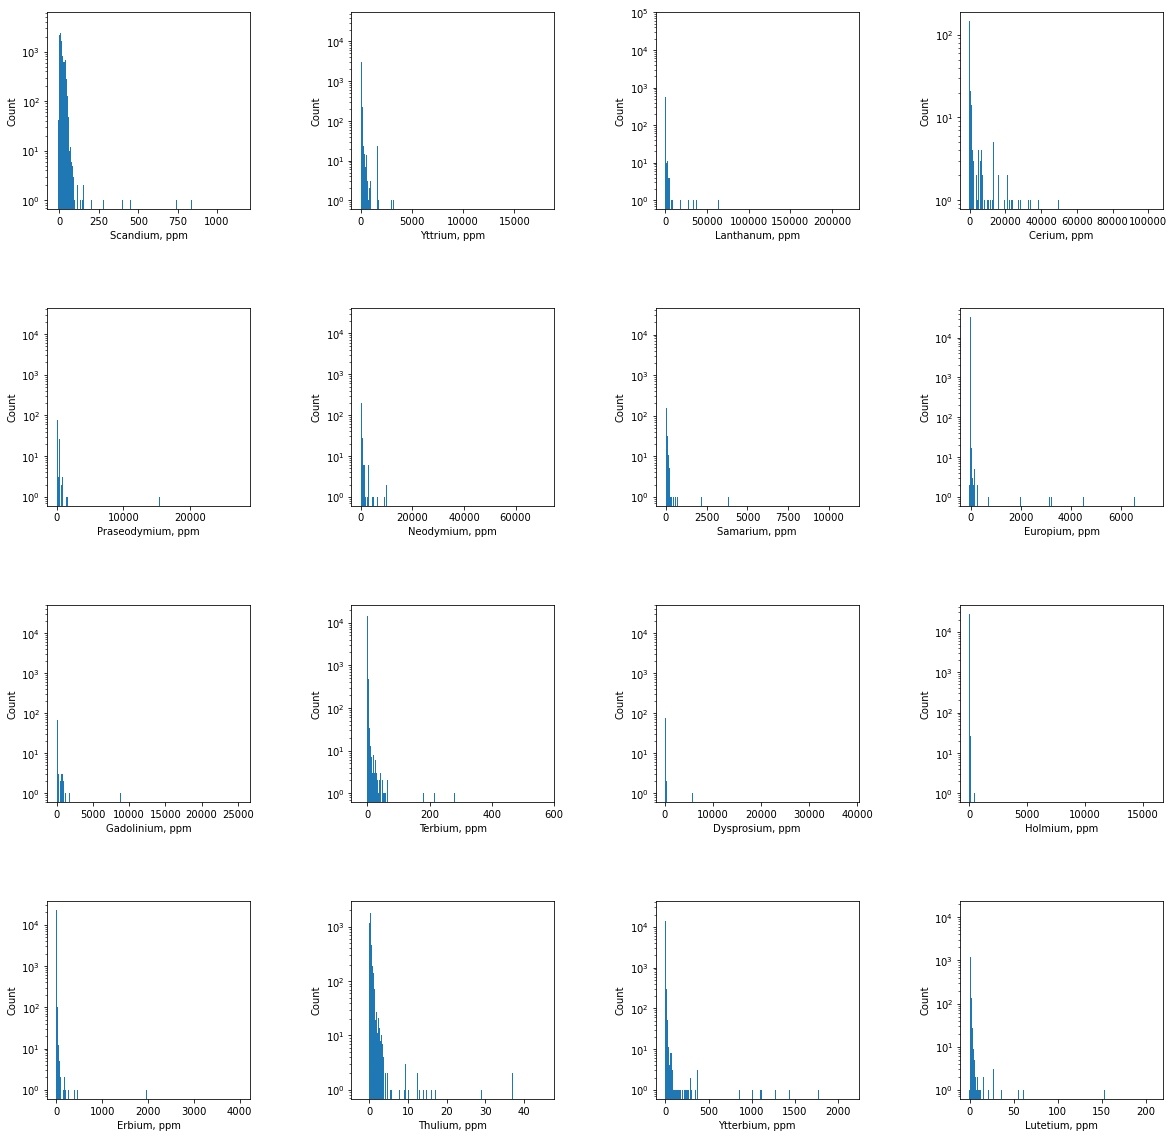

In [13]:
#plot rare earth distributions
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.subplot(4, 4, 1)  
plt.hist(x=df['sc_ppm'], log=True, bins = 1000)
plt.xlabel("Scandium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 2)  
plt.hist(x=df['y_ppm'], log=True, bins = 1000)
plt.xlabel("Yttrium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 3)  
plt.hist(x=df['la_ppm'], log=True, bins = 1000)
plt.xlabel("Lanthanum, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 4)  
plt.hist(x=df['c_ppm'], log=True, bins = 1000)
plt.xlabel("Cerium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 5)  
plt.hist(x=df['pr_ppm'], log=True, bins = 1000)
plt.xlabel("Praseodymium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 6)  
plt.hist(x=df['nd_ppm'], log=True, bins = 1000)
plt.xlabel("Neodymium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 7)  
plt.hist(x=df['sm_ppm'], log=True, bins = 1000)
plt.xlabel("Samarium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 8)  
plt.hist(x=df['eu_ppm'], log=True, bins = 1000)
plt.xlabel("Europium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 9) 
plt.hist(x=df['gd_ppm'], log=True, bins = 1000)
plt.xlabel("Gadolinium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 10)  
plt.hist(x=df['tb_ppm'], log=True, bins = 1000)
plt.xlabel("Terbium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 11)  
plt.hist(x=df['dy_ppm'], log=True, bins = 1000)
plt.xlabel("Dysprosium, ppm")
plt.ylabel("Count")

plt.subplot(4,4,12)  
plt.hist(x=df['ho_ppm'], log=True, bins = 1000)
plt.xlabel("Holmium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 13)  
plt.hist(x=df['er_ppm'], log=True, bins = 1000)
plt.xlabel("Erbium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 14)  
plt.hist(x=df['tm_ppm'], log=True, bins = 1000)
plt.xlabel("Thulium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 15) 
plt.hist(x=df['yb_ppm'], log=True, bins = 1000)
plt.xlabel("Ytterbium, ppm")
plt.ylabel("Count")

plt.subplot(4, 4, 16)  
plt.hist(x=df['lu_ppm'], log=True, bins = 1000)
plt.xlabel("Lutetium, ppm")
plt.ylabel("Count")

plt.show()

In [14]:
#Keep the data where rare earths > 1, assume rare earths = 0 did not have assays
df_rare_earth=df2.loc[df2['rare_earth'] >1]
df_rare_earth.describe()


,sample_id,latitude,longitude,quartz,feldspar,lithics,p_velocity,density_model,heat_production,heat_production_mass,f_ppm,cl_ppm,br__ppm,i_ppm,h_ppm,c_ppm,n_ppm,p_ppm,s_ppm,al_ppm,as_ppm,ag_ppm,au_ppm,b_ppm,ba_ppm,be_ppm,bi_ppm,ca_ppm,cd_ppm,co_ppm,cr_ppm,cs_ppm,cu_ppm,fe_ppm,ga_ppm,ge_ppm,hf_ppm,hg_ppm,in_ppm,ir_ppm,k_ppm,li_ppm,mg_ppm,mn_ppm,mo_ppm,na_ppm,ni_ppm,nb_ppm,os_ppm,pa_ppm,pb_ppm,pd_ppm,pt_ppm,rb_ppm,re_ppm,rh_ppm,ru_ppm,sb_ppm,se_ppm,si_ppm,sn_ppm,sr_ppm,ta_ppm,te_ppm,th_ppm,ti_ppm,tl_ppm,w_ppm,v_ppm,u_ppm,zn_ppm,zr_ppm,sio2,tio2,al2o3,cr2o3,fe2o3,fe2o3_tot,feo,feo_tot,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,h2o_plus,h2o_minus,h2o_tot,co2,so3,bao,caco3,mgco3,loi,rb87_sr86,sr87_sr86,nd143_nd144,sm147_nd144,lu176_hf177,hf176_hf177,re187_os186,re187_os188,os187_os188,pb206_pb204,pb207_pb204,pb208_pb204,th232_pb204,th232_u238,u238_pb204,epsilon_hf,epsilon_nd,epsilon_sr,age_min,age,age_max,age_sd,mg_number,fe_number,mali,asi,maficity,cia,wip,spar,qtzindex,r1,r2,rare_earth
count,7.955600e+04,79477.000000,79445.000000,351.000000,351.000000,351.000000,43005.000000,42295.000000,28282.000000,2.871800e+04,69459.000000,35518.000000,683.000000,191.000000,0.0,851.000000,0.0,14491.000000,26713.000000,16352.000000,39133.000000,22428.000000,6117.000000,19489.000000,76231.000000,38436.000000,24916.000000,23186.000000,11823.000000,46054.000000,68627.000000,32914.000000,68879.000000,27324.000000,54617.000000,12969.000000,34797.000000,6588.000000,2621.000000,773.000000,20798.000000,38204.000000,22977.000000,23930.000000,44177.000000,6.894000e+03,68140.000000,63251.000000,74.000000,0.0,64291.000000,9851.000000,3145.000000,65033.000000,206.000000,310.000000,291.000000,25062.000000,13056.000000,0.0,29958.000000,74482.000000,39536.000000,10442.000000,56921.000000,25276.000000,5217.000000,14803.000000,66100.000000,54899.000000,68562.000000,74637.000000,40361.000000,39808.000000,40086.000000,907.000000,18565.000000,11030.000000,18838.000000,4806.000000,39879.000000,40193.000000,37814.000000,210.000000,40689.000000,39749.000000,132.000000,37367.000000,5035.000000,4347.000000,528.000000,7965.000000,340.000000,197.000000,606.000000,10.000000,21099.000000,1011.000000,2659.000000,2530.000000,1012.000000,110.000000,336.000000,5.000000,184.000000,224.000000,1478.000000,1469.000000,1469.000000,49.000000,30.000000,79.000000,1.0,20.000000,1.0,16191.000000,16519.000000,16940.000000,1704.000000,46228.000000,46228.000000,74836.000000,74758.000000,46228.000000,74760.000000,42593.000000,74836.000000,74577.000000,73571.000000,46261.000000,79556.000000
mean,2.072423e+05,20.431740,14.243244,71.550731,12.786875,15.662394,6.921931,2885.102973,1.516824,5.347133e-04,890.008412,494.864637,19.216469,2.178761,NaN,6843.758092,NaN,2577.827939,2686.810731,42279.111306,128.102501,4.218043,324.680273,151.104292,804.446393,5.368062,1.929022,30148.655370,6.337634,32.572819,177.838672,4.878678,259.176325,36567.153016,21.361869,1.638015,5.813307,9.187495,1.354908,3.997116,18784.565601,40.825393,14421.781529,683.881477,21.591084,-2.554465e+03,108.189229,31.095356,171.247150,NaN,86.245801,6.180646,36.776777,124.011917,74.334599,19.236337,40.505127,18.258058,2.187188,NaN,5.858468,397.023785,1.774670,4.142672,20.263051,3183.075998,24.244031,173.985862,121.783612,114.756388,216.498663,236.157630,64.406263,0.701859,14.562124,0.253519,3.207935,5.423297,3.325412,5.744302,2.751637,4.018073,0.114105,0.151040,2.858006,3.390685,0.012311,0.222060,1.220738,0.667928,1.116940,0.933400,1.635010,0.105632,29.630706,4.597000,2.019378,10.818311,0.709840,0.512604,0.138858,0.019521,0.282965,3697.100000,228.443092,0.879635,19.069526,15.709244,39.111788,73.238137,3.211755,30.702154,12.9,2.479500,9.7,481.558605,476.792495,462.722348,9.018776,0.472946,0.682508,2.666036,1.078847,0.222046,48.465702,77.116168,-0.097962,0.171958,2.360563,1.240898,297.274838
std,1.814439e+05,31.629374,100.506345,20.067902,6.052138,22.329039,0.546291,154.994896,4.365103,1.475724e-03,4872.880620,2177.991778,242.005051,8.897664,Na

Text(0, 0.5, 'Count')

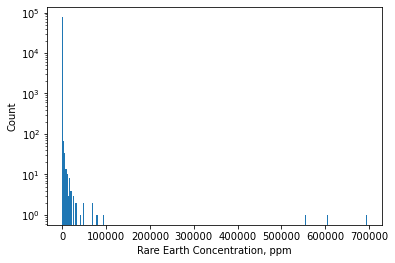

In [15]:
#histogram of rare earth metals
plt.hist(x=df_rare_earth['rare_earth'], log=True, bins = 1000)
plt.xlabel("Rare Earth Concentration, ppm")
plt.ylabel("Count")

#quite a few very low counts

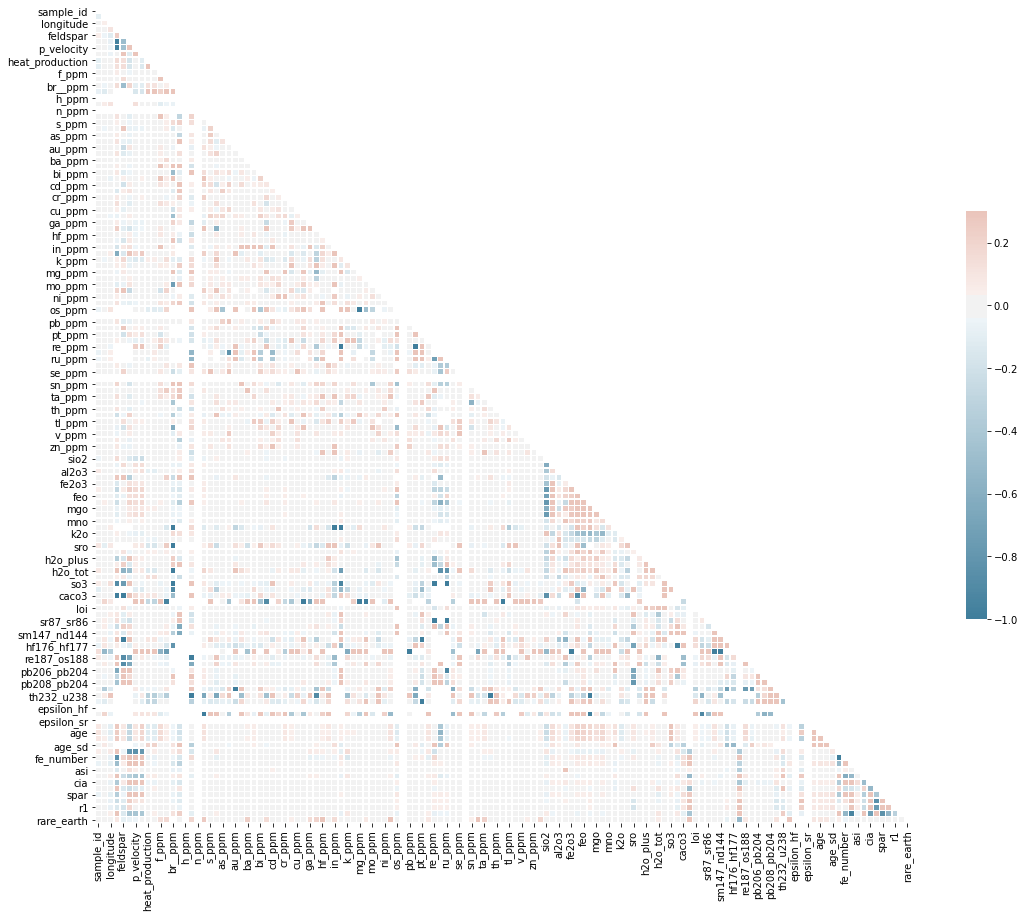

In [21]:
# Compute the correlation matrix
corr = df_rare_earth.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [17]:
#try XGBoost classifer - make 0 and 1 for rare earth column.  
#at about 200, more a balance between 0 and 1.  Relatively few over 500, accuracy goes up though
#when more selective and pick a higher value for ppm cut off
#changed to 1000 and then used a higher value for scale_pos_weight with XGBoost
#seems to be a good combination of accuracy and not too many false positive points

df_class=df_rare_earth
mask2 = df_class['rare_earth'] < 1000
df_class.loc[mask2, 'rare_earth'] = 0
mask = df_class['rare_earth'] >= 1000
df_class.loc[mask, 'rare_earth'] = 1

C:\Users\jbike\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
df_class['rare_earth'].value_counts()

0.0    77850
1.0     1706
Name: rare_earth, dtype: int64

In [23]:
# Split our preprocessed data into our features and target arrays for regression problems
y = df_class["rare_earth"]
X = df_class.drop(["rare_earth"], axis = 1)


# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [24]:
#use decision tree to see if that improves and look at shap plot to determine relative importance of parameters
#scale pos weight parameter in XGBclassifier changes the balancing of postive and negative points
#default is 1, the higher you go the more weighting to the positive points
#in our case, not many positive points, so go up a bit and see if can improve the 
#confusion matrix and ability to find the rare earths vs correctly classifying the negatives
#even though misclassify some of the negatives as rare earth
#150 is about optimum for scale_pos_weight and cutting down on the false negatives, even though it drops accuracy a bit

model_class = XGBClassifier(scale_pos_weight = 150, random_state=10)
model_class.fit(X_train, y_train)
y_pred = model_class.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score: %f" % (accuracy))

C:\Users\jbike\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
RMSE: 0.108468
Accuracy score: 0.988235


In [25]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Displaying results
print("Confusion Matrix")
display(cm_df)


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,19297,161
Actual 1,73,358


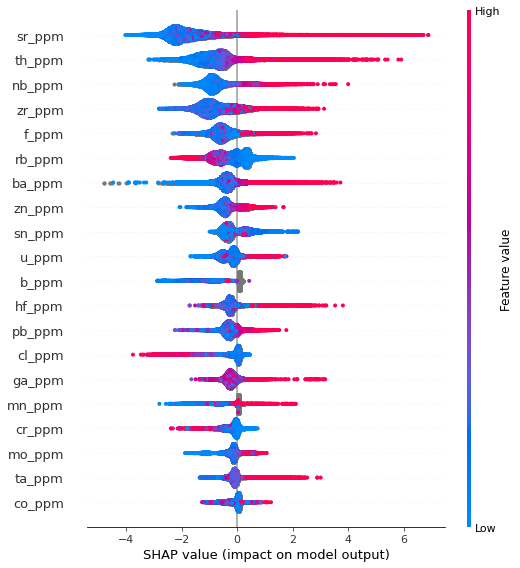

In [26]:
#look at feature importance
import shap
explainer = shap.TreeExplainer(model_class)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

#red to right - positive correlation, blue to right = negative correlation
#the more colors are separated, the better the feature

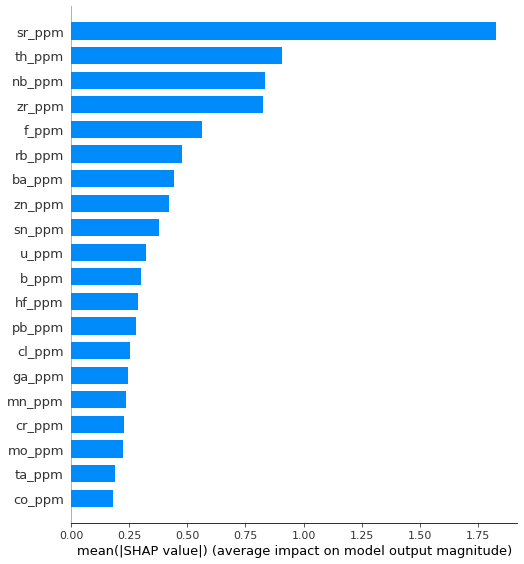

In [27]:
#alternative shap plot feature values
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')

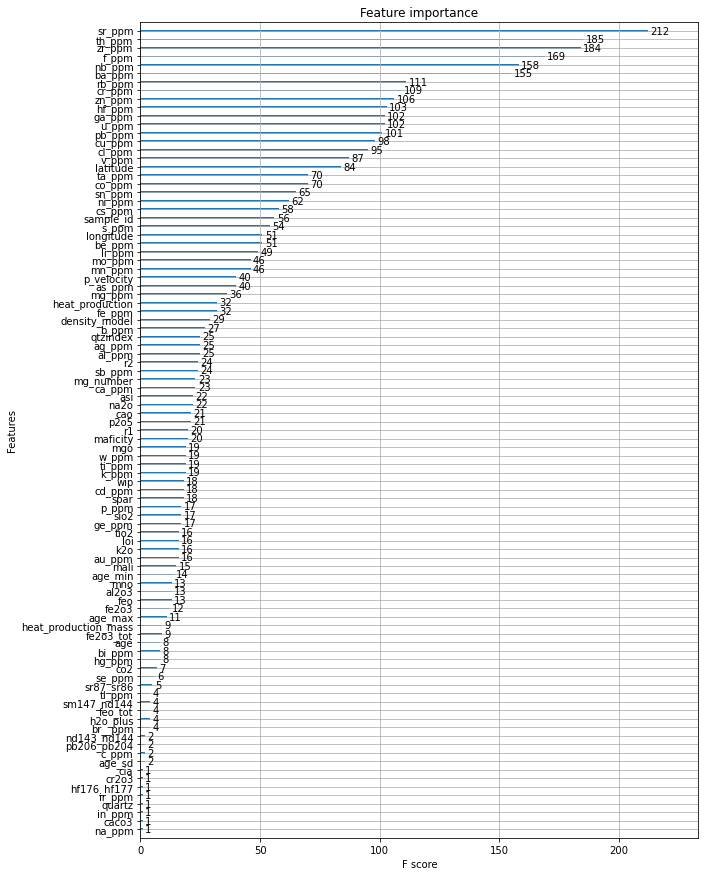

In [28]:
# plot feature importance using built-in function and looks @ all features
# plot feature importance
ax = xgboost.plot_importance(model_class)
fig = ax.figure
fig.set_size_inches(10, 15)

In [29]:
#use model to predict if rare earths in full dataset (even the rows that did not have rare earth data)
features_full_dataset = df2.drop(['rare_earth'], axis=1)
y_pred_all = model_class.predict(features_full_dataset)
y_pred_all

array([0., 0., 0., ..., 0., 0., 0.])

In [30]:
#add the prediction array and latittude and longitude to a dataframe for plotting on a map
predict_full_dataset=features_full_dataset
predict_full_dataset['rare_earth_predict'] = y_pred_all.tolist()
predict_full_dataset['latitude']=df['latitude']
predict_full_dataset['longitude']=df['longitude']
predict_full_dataset['sample_id']=df['sample_id']
predict_full_dataset.head()

,sample_id,latitude,longitude,quartz,feldspar,lithics,p_velocity,density_model,heat_production,heat_production_mass,f_ppm,cl_ppm,br__ppm,i_ppm,h_ppm,c_ppm,n_ppm,p_ppm,s_ppm,al_ppm,as_ppm,ag_ppm,au_ppm,b_ppm,ba_ppm,be_ppm,bi_ppm,ca_ppm,cd_ppm,co_ppm,cr_ppm,cs_ppm,cu_ppm,fe_ppm,ga_ppm,ge_ppm,hf_ppm,hg_ppm,in_ppm,ir_ppm,k_ppm,li_ppm,mg_ppm,mn_ppm,mo_ppm,na_ppm,ni_ppm,nb_ppm,os_ppm,pa_ppm,pb_ppm,pd_ppm,pt_ppm,rb_ppm,re_ppm,rh_ppm,ru_ppm,sb_ppm,se_ppm,si_ppm,sn_ppm,sr_ppm,ta_ppm,te_ppm,th_ppm,ti_ppm,tl_ppm,w_ppm,v_ppm,u_ppm,zn_ppm,zr_ppm,sio2,tio2,al2o3,cr2o3,fe2o3,fe2o3_tot,feo,feo_tot,mgo,cao,mno,nio,k2o,na2o,sro,p2o5,h2o_plus,h2o_minus,h2o_tot,co2,so3,bao,caco3,mgco3,loi,rb87_sr86,sr87_sr86,nd143_nd144,sm147_nd144,lu176_hf177,hf176_hf177,re187_os186,re187_os188,os187_os188,pb206_pb204,pb207_pb204,pb208_pb204,th232_pb204,th232_u238,u238_pb204,epsilon_hf,epsilon_nd,epsilon_sr,age_min,age,age_max,age_sd,mg_number,fe_number,mali,asi,maficity,cia,wip,spar,qtzindex,r1,r2,rare_earth_predict
0,1,-53.100000,73.800000,NaN,NaN,NaN,6.378562,2719.911899,NaN,NaN,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,49.20,0.42,6.07,NaN,1.22,8.94,6.93,8.04,18.01,14.71,0.17,NaN,0.08,0.13,NaN,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.642160,0.538874,-8.010000,0.459115,0.445815,31.465292,113.086950,-0.294859,-0.006397,0.492100,2.217078,0.0
1,2,-53.150000,73.670000,NaN,NaN,NaN,6.373094,2674.271335,9.206429,0.003443,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,49.26,1.79,17.49,NaN,NaN,7.34,NaN,NaN,5.62,6.44,0.12,NaN,3.09,4.66,NaN,0.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.46,NaN,NaN,0.512306,0.169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534859,0.645862,0.250000,0.928748,0.140027,48.152899,73.269179,-0.200548,0.151418,2.209422,1.049967,0.0
2,3,-53.080000,73.670000,NaN,NaN,NaN,6.369678,2681.068501,10.989396,0.004099,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,48.90,2.70,13.30,NaN,6.01,NaN,7.02,NaN,7.00,10.60,0.19,NaN,0.33,2.58,NaN,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.71164,0.512827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537982,0.642984,-6.569399,0.847798,0.391939,45.881544,60.859279,-0.214998,0.148854,2.049653,1.601753,0.0
3,4,-53.150000,73.670000,NaN,NaN,NaN,6.390982,2677.630522,9.082251,0.003392,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,49.10,1.93,13.70,NaN,NaN,NaN,13.84,NaN,6.74,11.59,NaN,NaN,0.16,2.17,NaN,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.537679,0.643264,-4.823892,0.831326,0.260319,45.394750,70.060311,-0.227992,0.133249,2.044396,1.515187,0.0
4,5,33.421055,130.398294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3660.0,NaN,NaN,NaN,NaN,NaN,NaN,304.0,NaN,NaN,NaN,NaN,NaN,541.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,591.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [31]:
features_full_dataset['rare_earth_predict'].value_counts()

0.0    1018001
1.0       4091
Name: rare_earth_predict, dtype: int64

In [33]:
#read in shape files with world map
map = gpd.read_file('.\\maps\\World_Countries__Generalized_.shp')

In [34]:
#create geometry points with lat & long
geometry = [Point(xy) for xy in zip(features_full_dataset["longitude"], features_full_dataset["latitude"])]
geometry[:3]
#crs = coordinated reference system
crs = {'init': 'epsg:4326'}
geo_df=gpd.GeoDataFrame(features_full_dataset, crs=crs, geometry = geometry)  

Text(0.5, 1.0, 'Predicted Rare Earth Concentrations < 1000 ppm')

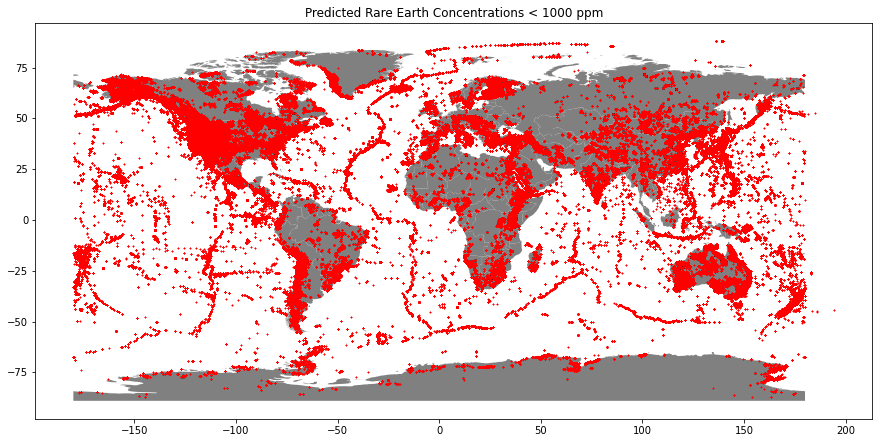

In [35]:
#create map with no rare earth points 
fig,ax=plt.subplots(figsize=(15,15))
map.plot(ax=ax, color="grey")
geo_df[geo_df['rare_earth_predict']==0].plot(ax=ax, markersize=1, color="red", marker='x')
plt.title('Predicted Rare Earth Concentrations < 1000 ppm')

Text(0.5, 1.0, 'Predicted Rare Earth Concentrations > 1000 ppm')

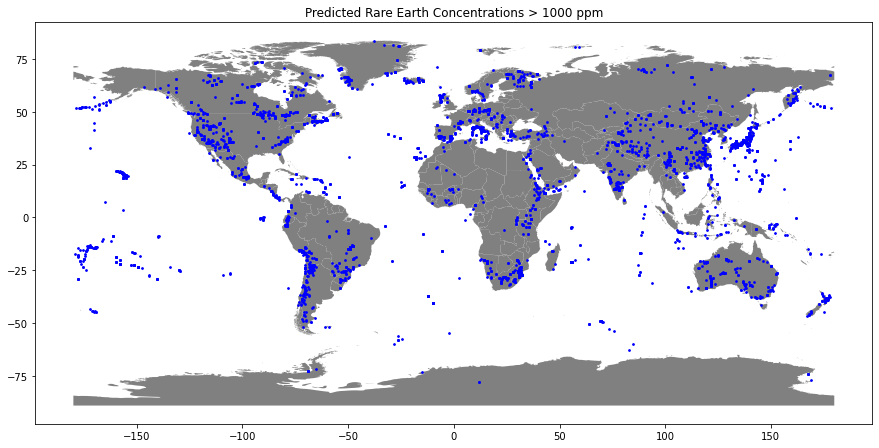

In [36]:
#create map with rare earth points @ cutoff >1000 ppm value
fig,ax=plt.subplots(figsize=(15,15))
map.plot(ax=ax, color="grey")
geo_df[geo_df['rare_earth_predict']==1].plot(ax=ax, markersize=3, color="blue", marker ="o")
plt.title('Predicted Rare Earth Concentrations > 1000 ppm')

In [37]:
#create geometry points with lat & long
geometry2 = [Point(xy) for xy in zip(mines["longitude"], mines["latitude"])]
geometry2[:3]
#crs = coordinated reference system
crs = {'init': 'epsg:4326'}

#the additional USGS dataset with known rare earths
geo_df2=gpd.GeoDataFrame(mines, crs=crs, geometry = geometry2)   

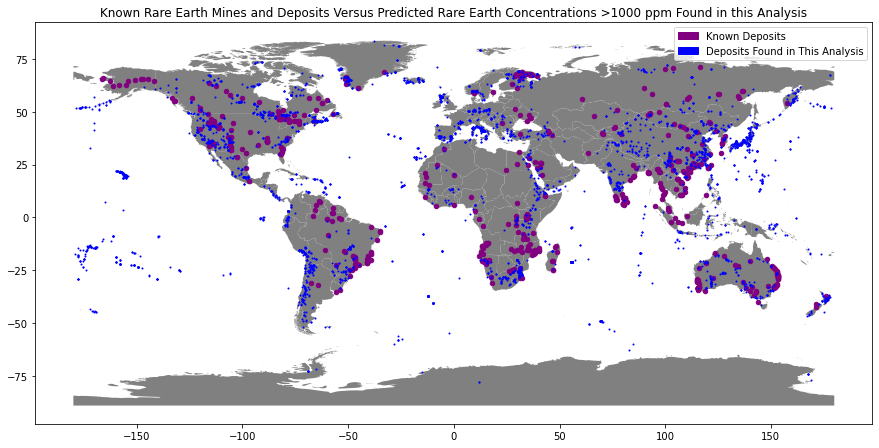

In [38]:
#df2 is known deposits  (purple)
#blue dots are additional potential deposits from this analysis
fig,ax=plt.subplots(figsize=(15,15))

plt.title('Known Rare Earth Mines and Deposits Versus Predicted Rare Earth Concentrations >1000 ppm Found in this Analysis')

map.plot(ax=ax, color="grey")
plot_A = geo_df2[geo_df2['latitude']>-1000].plot(ax=ax, markersize=20, color="purple", marker='o', label = "Known Deposits")
plot_B = geo_df[geo_df['rare_earth_predict']==1].plot(ax=ax, markersize=1, color="blue", marker ="o", label = "Rare Earth Found in Analysis")

import matplotlib.patches as mpatches
purple_patch = mpatches.Patch(color='purple', label='Known Deposits')
blue_patch = mpatches.Patch(color='blue', label='Deposits Found in This Analysis')
plt.legend(handles=[purple_patch, blue_patch])


In [39]:
#merge information to get the data that want to output
merge_df1=features_full_dataset[['sample_id','rare_earth_predict']]
merge_df2 = df2[['sample_id', 'rare_earth', 'latitude', 'longitude', 'au_ppm', 'ag_ppm']]
merge_df3 = df[['sample_id','country','sc_ppm', 'y_ppm', 'la_ppm', 'ce_ppm', 'pr_ppm', 'nd_ppm', 'sm_ppm', 'eu_ppm', 'gd_ppm', 'tb_ppm', 'dy_ppm', 'ho_ppm', 'er_ppm', 'tm_ppm', 'yb_ppm', 'lu_ppm']]

output_df_full = merge_df1.merge(merge_df2, how ='inner', on='sample_id')

output_df_full=output_df_full.merge(merge_df3,how='inner', on='sample_id')


output_df_full.head()
output_df_full.to_csv('output_world.csv', index=False)


In [ ]:
#code to get just the positive points - easier to map with a small subset and mostly only interested in positive!
#write to json
df_positive = output_df_full.loc[((output_df_full['rare_earth_predict'] == 1) | (output_df_full['au_ppm'] > 5)  | (output_df_full['ag_ppm']>5))]
df_positive=df_positive.fillna(0)
df_positive.to_json('mini_world.json')
df_positive.to_csv('output_positive.csv', index=False)

In [ ]:
#write to geojson

def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

cols = ['sample_id','rare_earth_predict','country','rare_earth','au_ppm','ag_ppm','sc_ppm','y_ppm','la_ppm','sm_ppm','eu_ppm','gd_ppm','tb_ppm','dy_ppm','ho_ppm','er_ppm','tm_ppm','yb_ppm','lu_ppm']
geojson = df_to_geojson(df_positive, cols)

#write to a geojson file
with open('positive_data.geojson', 'w', encoding='utf-8') as f:
    json.dump(geojson, f, ensure_ascii=False)

In [45]:
#output results

conn_string= 'postgres://dbstring&password'
alchemyEngine=create_engine(conn_string)

# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

df_positive.to_sql('output_positive', con=alchemyEngine)
dbConnection.close();